In [106]:
from prelim import do_prelim_on_single_feature
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
import numpy as np
from matplotlib import pyplot as plt
import itertools
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from shapely.geometry import Polygon
from scipy import spatial
import alphashape

In [2]:
uri = "localhost:27017"
client = MongoClient(uri, server_api=ServerApi('1'))

client.admin.command('ping')

{'ok': 1.0}

In [3]:
db = client.test
historical_evolution_data = db.historicalEvolutionData
problem_instances = db.probleminstances
db_prelim_information = db.prelimInformation

In [31]:
experiment_id = "31-07-800"

transformed_projection_matrix_values = {
    "stationCount" : [-0.1962,0.0415],
    "totalPassengerCount": [-0.6727,0.5595],
    "passengerRatio": [0.2033,0.8956],
    "stdDevRailCarriageCapacity": [-0.4999,0.0516],
    "totalCongestion": [0.7317,0.0484],
    "blockedPassengerRatio": [-0.1842,0.5807],
}

x_plot_lim = [-6, 6]
y_plot_lim = [-5, 6]

sorted_feature_names = sorted(transformed_projection_matrix_values.keys())
transformed_projection_matrix = []
for i in range(0, len(sorted_feature_names)):
    transformed_projection_matrix.append(transformed_projection_matrix_values[sorted_feature_names[i]])

projection_matrix = np.array(transformed_projection_matrix).transpose()

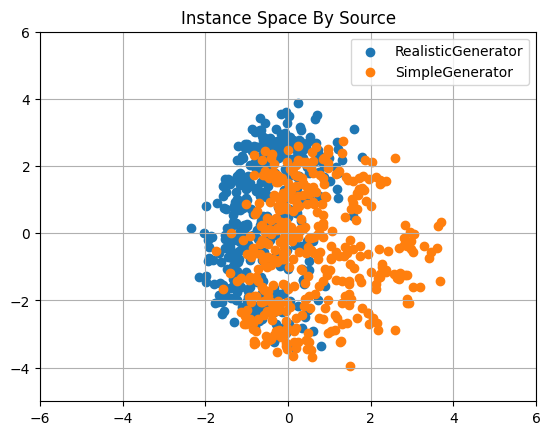

In [43]:
def get_instances_and_coordinates():
    prelim_information = db_prelim_information.find({"experimentId" : experiment_id})
    instances = problem_instances.find({"experimentId" : experiment_id})
    instance_feature_vectors = list(map(lambda x: (x, convert_instance_to_feature_vector(x, prelim_information[0])), instances))
    return list(map(lambda x: (x[0], convert_feature_vector_to_coordinates(x[1])), instance_feature_vectors))

def convert_instance_to_feature_vector(instance, prelim_data):
    feature_vector = {}
    for feature in prelim_data["prelimDataOfFeatures"].keys():
        feature_vector[feature] = do_prelim_on_single_feature(instance["featureDescription"][feature], prelim_data["prelimDataOfFeatures"][feature])
    return feature_vector

def convert_feature_vector_to_coordinates(feature_vector):
    sorted_features= sorted(feature_vector.keys())
    vector_array = []
    for i in range(0, len(sorted_features)):
        vector_array.append(feature_vector[sorted_features[i]])
    vector = np.array(vector_array)
    return np.matmul(projection_matrix, vector)

def visualize_instance_space(instance_coordinate_pairs):
        instance_coordinate_pairs.sort(key = lambda x: x[0]["featureDescription"]["source"])
        grouped_instances_by_source = itertools.groupby(instance_coordinate_pairs, key= lambda x: x[0]["featureDescription"]["source"])
        for key, group in grouped_instances_by_source:
            group_list = list(group)
            x_coords = [pair[1][0] for pair in group_list]
            y_coords = [pair[1][1] for pair in group_list]
            plt.scatter(x_coords, y_coords, label=key)

        plt.legend()
        plt.grid()
        plt.title("Instance Space By Source")
        plt.xlim(x_plot_lim)
        plt.ylim(y_plot_lim)
        plt.show()

instances_and_coordinates = get_instances_and_coordinates()
visualize_instance_space(instances_and_coordinates)


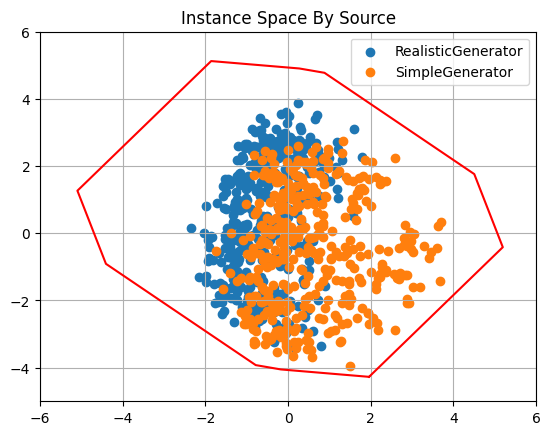

In [75]:
def visualize_instance_space_with_potential_borders(instance_coordinate_pairs, border_coords):
    instance_coordinate_pairs.sort(key = lambda x: x[0]["featureDescription"]["source"])
    grouped_instances_by_source = itertools.groupby(instance_coordinate_pairs, key= lambda x: x[0]["featureDescription"]["source"])
    for key, group in grouped_instances_by_source:
        group_list = list(group)
        x_coords = [pair[1][0] for pair in group_list]
        y_coords = [pair[1][1] for pair in group_list]
        plt.scatter(x_coords, y_coords, label=key)

    xs, ys = zip(*border_coords)
    plt.plot(xs, ys, color='red')

    plt.legend()
    plt.grid()
    plt.title("Instance Space By Source")
    plt.xlim(x_plot_lim)
    plt.ylim(y_plot_lim)
    plt.show()

def create_border_coordinates(border_values):
    prelim_information = db_prelim_information.find({"experimentId" : experiment_id})
    prelim_data = prelim_information[0]
    for feature in prelim_data["prelimDataOfFeatures"].keys():
        for border_point in border_values:
            border_point[feature] = do_prelim_on_single_feature(border_point[feature], prelim_data["prelimDataOfFeatures"][feature])
    return list(map(lambda x: convert_feature_vector_to_coordinates(x), border_values))

likely_border = [
[1.95853117406013,-4.27258627094031],
[5.19426484024767,-0.414354835125923],
[4.5041355151608,1.7618085960723],
[0.880045820645803,4.7761296540596],
[0.27210393566415,4.90485192955848],
[-1.86137650848267,5.1252429330383],
[-5.09711017467021,1.26701149722391],
[-4.40698084958334,-0.909151933974313],
[-0.782891155068344,-3.92347299196162],
[-0.174949270086691,-4.05219526746049],
[1.95853117406013,-4.27258627094031]
]

instances_and_coordinates = get_instances_and_coordinates()
visualize_instance_space_with_potential_borders(instances_and_coordinates, likely_border)

In [111]:
instances_and_coordinates = get_instances_and_coordinates()
coords = list(map(lambda x: tuple(x[1].tolist()), instances_and_coordinates))

#poly = Polygon(coords)

# Extract the point values that define the perimeter of the polygon
#xx, yy = poly.exterior.coords.xy
#hull_coords = list(zip(xx,yy))
# = poly.exterior.coords

#hull = ConvexHull(coords)
#hull_coords = [coords[i] for i in hull.vertices]

alpha = 0.95 * alphashape.optimizealpha(coords)
hull = alphashape.alphashape(coords, alpha)
hull_pts = hull.exterior.coords.xy
print(hull_pts)
#hull = spatial.ConvexHull(coords, incremental=False, qhull_options='Qt')
#hull_coords = [coords[i] for i in hull.vertices]

TypeError: 'MultiPoint' object is not iterable

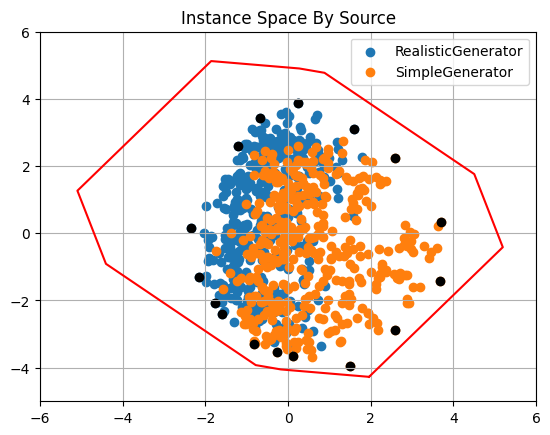

In [104]:
def visualize_instance_space_with_potential_borders_and_hull(instance_coordinate_pairs, border_coords, hull_coords):
    instance_coordinate_pairs.sort(key = lambda x: x[0]["featureDescription"]["source"])
    grouped_instances_by_source = itertools.groupby(instance_coordinate_pairs, key= lambda x: x[0]["featureDescription"]["source"])
    for key, group in grouped_instances_by_source:
        group_list = list(group)
        x_coords = [pair[1][0] for pair in group_list]
        y_coords = [pair[1][1] for pair in group_list]
        plt.scatter(x_coords, y_coords, label=key)

    xs, ys = zip(*border_coords)
    plt.plot(xs, ys, color='red')

    xs, ys = zip(*hull_coords)
    plt.scatter(xs, ys, color='black')

    plt.legend()
    plt.grid()
    plt.title("Instance Space By Source")
    plt.xlim(x_plot_lim)
    plt.ylim(y_plot_lim)
    plt.show()


visualize_instance_space_with_potential_borders_and_hull(instances_and_coordinates, likely_border, hull_coords)

In [110]:
print(coords)

[[-0.27224462926020043, 1.085694724919405], [0.381956442929383, -2.1523789342197945], [-0.799611766895406, -1.341158563106948], [2.277915754653391, -1.0060852884562743], [2.0248805868191004, 2.134550277442516], [-1.0340203016310427, -2.4639422632431973], [-0.8478903683419436, -2.8486805138174462], [0.8826186111543264, -1.071569639689157], [0.742758680974486, -2.5085326674778288], [1.0308325332549082, -0.38106920334167227], [-0.4607614601485165, -3.1673105575317515], [0.8928367378631396, 2.2320374825692637], [0.7472153014791986, -0.00038606606997271253], [-0.8980210404215837, -2.0579649500940653], [0.25465112809136936, 0.8133101735394019], [1.7556229026168155, -1.4577580623453559], [0.23566163729157663, 1.7107868770421795], [1.1805325003008247, -2.534129226932985], [0.23009459166301616, -3.2323270201372503], [1.7096198578496142, 1.656115755828214], [3.013936214723133, -1.5894655075549065], [0.7064260056891403, 0.6227911928310973], [1.4147458976628104, -0.5974140175101508], [0.8618102869